# 1️⃣ XGBoost for Multiclass Diabetes Classification

XGBoost is a gradient boosting algorithm optimized for speed and performance.  
It is well-suited for multiclass classification problems and handles imbalanced datasets efficiently when combined with SMOTE.


In [1]:
# ----------------------------
# Run Preprocessing Notebook
# ----------------------------
%run ./Preprocessing.ipynb

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Preprocessed data saved as joblib files!


## 1.1️⃣ Target and Selected Features

Selected features for diabetes classification:

- `HbA1c`, `BMI`, `AGE`, `Urea`, `Chol`, `VLDL`, `TG`, `Cr`, `LDL`  
Target variable: `Class` (0=Non-diabetic, 1=Pre-diabetic, 2=Diabetic)


In [2]:
y = df["Class"]
selected_features = ['HbA1c', 'BMI', 'AGE', 'Urea', 'Chol', 'VLDL', 'TG', 'Cr', 'LDL']
X = df[selected_features]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 1.3️⃣ Apply SMOTE

- Balances minority classes in the training set  
- Reduces model bias toward majority class


In [4]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


## 1.4️⃣ Train XGBoost Model

- **Objective:** `multi:softmax` for multiclass  
- **Number of classes:** 3  
- **Evaluation metric:** `mlogloss`


In [6]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

## 1.5️⃣ Predict on Test Set & Evaluate

- Metrics: Accuracy, Classification Report  
- Visualization: Confusion Matrix


Accuracy: 0.9622641509433962

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.89      1.00      0.94         8
           2       1.00      0.92      0.96        26

    accuracy                           0.96        53
   macro avg       0.95      0.97      0.96        53
weighted avg       0.97      0.96      0.96        53



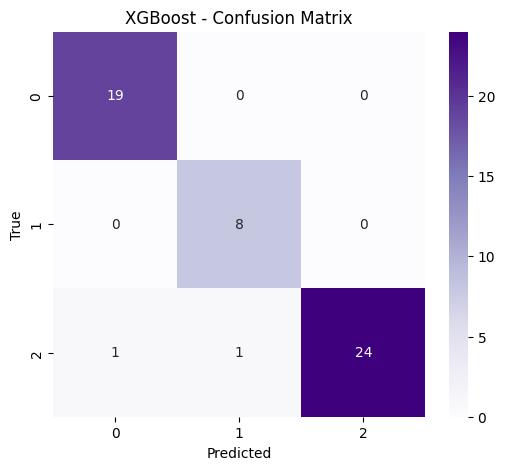

In [7]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 1.6️⃣ Hyperparameter Tuning with RandomizedSearchCV

- Optimizes multiclass **F1_macro score**  
- Explores combination of `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`


In [10]:
param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0, 0.5, 5)
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search_xgb.fit(X_train_res, y_train_res)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                        'gamma': array([0.   , 0.125, 0.25 , 0.375, 0.5  ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='f1_macro', verbose=2)

## 1.7️⃣ Best Parameters & Test Evaluation

- `best_params_` → Optimal combination of XGBoost hyperparameters  
- `best_score_` → Cross-validated F1_macro score

In [11]:
print("Best Hyperparameters:", random_search_xgb.best_params_)
print("Best F1_macro Score:", random_search_xgb.best_score_)

best_xgb = random_search_xgb.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("Test Accuracy after Hyperparameter Tuning:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report after Hyperparameter Tuning:\n",
      classification_report(y_test, y_pred_best))


Best Hyperparameters: {'subsample': np.float64(0.6), 'n_estimators': np.int64(300), 'max_depth': np.int64(12), 'learning_rate': np.float64(0.042222222222222223), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.6)}
Best F1_macro Score: 0.9868786310497508
Test Accuracy after Hyperparameter Tuning: 0.9811320754716981

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53



## 1.8️⃣ Key Insights

- Hyperparameter tuning improves **generalization**  
- XGBoost handles multiclass problems efficiently with **gradient boosting**  
- Confusion matrix shows strong predictions for majority classes  
- Can be compared with **Random Forest** and **Gradient Boosting** to select the best model
